In [6]:
import sys

!{sys.executable} -m pip install sklearn

## Rough Notes
1. Read the dataset and analzye the quantity of type A tomatoes
2. We only consider entries from 19/02/2020 till 29/05/2020 since all teams have data within that timeframe.
3. We take into account type A tomatoes which can be commercially traded.
4. Weather dataset had 71 null values 
5. Train without outlier analysis + Train with outlier analysis

## Choice of dataset
We have datasets from 6 teams and to build our model we need to pick the dataset generated by the team which produces the most type A tomatoes since that has the optimum parameters. Below, we analyse the total production of type A tomatoes across the different teams to chose the dataset with which we work on during model building.

In [7]:
import pandas as pd

pd.options.mode.chained_assignment = None

the_automators_df = pd.read_csv("../dataset/automators_production.csv")

the_automators_df.head(10)

,time,ProdA,ProdB,avg_nr_harvested_trusses,Truss development time,Nr_fruits_ClassA,Weight_fruits_ClassA,Nr_fruits_ClassB,Weight_fruits_ClassB
0,43880.04,0.037,0.0,0.1,50.0,NaN,128.0,0,0
1,43885.04,0.767,0.0,0.9,54.5,136.0,1271.0,0,0
2,43889.04,0.232,0.0,0.6,51.0,89.0,788.0,0,0
3,43894.04,0.778,0.0,1.5,55.1,226.0,2001.0,0,0
4,43899.04,0.248,0.0,0.9,53.6,133.0,1144.0,0,0
5,43903.04,0.354,0.0,0.7,52.4,83.0,811.0,0,0
6,43908.04,0.795,0.0,1.0,53.3,126.0,1230.0,0,0
7,43913.04,0.486,0.0,0.9,54.9,148.0,1297.5,0,0
8,43917.04,0.454,0.0,0.9,52.6,126.0,1069.0,0,0
9,43922.00,0.697,0.0,0.6,54.0,92.0,777.0,0,0


In [8]:
import xlrd
import pandas as pd
from datetime import datetime

def load_data(csv_file):
    df = pd.read_csv(csv_file)
    return df

# convert from excel date format to datetime
def convert_xldate_to_date(xl_date):
    datetime = xlrd.xldate_as_datetime(xl_date, 0)
    date = datetime.date()
    return date

def preprocess_prod_df(df):
    # remove rows for which all entries are NaN
    df = df.dropna(axis=0, how="all")
    # convert excel date entries into datetime  
    df["time"] = df["time"].apply(lambda x: convert_xldate_to_date(x))
    # convert kg/m to kg 
    df["ProdA"] = df["ProdA"].apply(lambda x: x*62.5)
    # set the index of the df to time
    df.set_index("time", inplace=True)
    return df

# get the total amount of type A tomatoes produced 
def get_production(df):
    from_date = datetime.strptime("2020-02-19", "%Y-%m-%d").date()
    to_date = datetime.strptime("2020-05-29", "%Y-%m-%d").date()
    total_prod = df.loc[from_date:to_date, "ProdA"].sum()
    return total_prod

In [9]:
the_automators_df

,time,ProdA,ProdB,avg_nr_harvested_trusses,Truss development time,Nr_fruits_ClassA,Weight_fruits_ClassA,Nr_fruits_ClassB,Weight_fruits_ClassB
0,43880.04,0.037,0.000,0.1,50.0,NaN,128.0,0,0
1,43885.04,0.767,0.000,0.9,54.5,136.0,1271.0,0,0
2,43889.04,0.232,0.000,0.6,51.0,89.0,788.0,0,0
3,43894.04,0.778,0.000,1.5,55.1,226.0,2001.0,0,0
4,43899.04,0.248,0.000,0.9,53.6,133.0,1144.0,0,0
5,43903.04,0.354,0.000,0.7,52.4,83.0,811.0,0,0
6,43908.04,0.795,0.000,1.0,53.3,126.0,1230.0,0,0
7,43913.04,0.486,0.000,0.9,54.9,148.0,1297.5,0,0
8,43917.04,0.454,0.000,0.9,52.6,126.0,1069.0,0,0
9,43922.00,0.697,0.000,0.6,54.0,92.0,777.0,0,0


### Load, preprocess and extract the total amount of type tomatoes by each team

In [10]:
# team TheAutomators
the_automators_df = load_data("../dataset/automators_production.csv")
the_automators_df = preprocess_prod_df(the_automators_df)
automators_produce = get_production(the_automators_df)

# team Grower
grower_df = load_data("../dataset/grower_production.csv")
grower_df = preprocess_prod_df(grower_df)
grower_produce = get_production(grower_df)

# team Digilog
digilog_df = load_data("../dataset/digilog_production.csv")
digilog_df = preprocess_prod_df(digilog_df)
digilog_produce = get_production(digilog_df)

# team AICU
aicu_df = load_data("../dataset/aicu_production.csv")
aicu_df = preprocess_prod_df(aicu_df)
aicu_produce = get_production(aicu_df)

# team IUACAAS
iuacaas_df = load_data("../dataset/iuacaas_production.csv")
iuacaas_df = preprocess_prod_df(iuacaas_df)
iuacaas_produce = get_production(iuacaas_df)

# team Automatoes
automatoes_df = load_data("../dataset/automatoes_production.csv")
automatoes_df = preprocess_prod_df(automatoes_df)
automatoes_produce = get_production(automatoes_df)

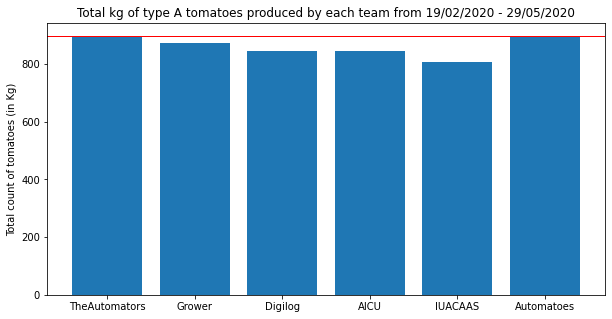

In [11]:
import matplotlib.pyplot as plt
import numpy as np

teams = ["TheAutomators", "Grower", "Digilog", "AICU", "IUACAAS", "Automatoes"]
total_produce = [automators_produce, grower_produce, digilog_produce, aicu_produce, iuacaas_produce, automatoes_produce]
threshold = np.array(total_produce).max()

plt.figure(figsize=(10,5))
plt.bar(teams, total_produce)
plt.axhline(y=threshold, linewidth=1, color='r')
plt.title("Total kg of type A tomatoes produced by each team from 19/02/2020 - 29/05/2020")
plt.ylabel("Total count of tomatoes (in Kg)")
plt.show()

### Finding

Since **TheAutomators** and **Automatoes** yeild the highest amout of tomatoes during the given time period, we want to consider their environment conditions (especially the **GreenHouse Climate** conditions) to train an efficient forecasting model. However, if our model is underfit, then we can also include the dataset from
remaining teams as well since the margin of difference is rather small. 

<span style="color:red">Suggestion</span>:

We can decide on a threshold, based on the amount of type A tomatoes generated, which "qualifies" a team's dataset and in turn it's environmental conditions as gold standard such that only these conditions can be taken into account during training a ML/DNN model. 

## Predict the greenhouse air temperature for the next 24h in every 1h intervals

### Load and transform the weather dataset

In [12]:
weather_df = load_data("../dataset/weather.csv")

In [13]:
weather_df

,time,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rain,Rhout,Tout,Winddir,Windsp
0,43815.00000,6.220954,0.0,0.000000e+00,-72.0,215.0,0.0,80.6,6.9,32.0,4.7
1,43815.00347,6.220954,0.0,0.000000e+00,-73.0,0.0,0.0,80.6,6.9,32.0,4.7
2,43815.00694,6.205565,0.0,0.000000e+00,-76.0,0.0,0.0,80.4,6.9,32.0,4.7
3,43815.01042,6.190173,0.0,0.000000e+00,-77.0,0.0,0.0,80.2,6.9,32.0,4.7
4,43815.01389,6.162624,0.0,0.000000e+00,-75.0,0.0,0.0,80.9,6.7,32.0,4.7
...,...,...,...,...,...,...,...,...,...,...,...
47804,43980.98611,9.286397,0.0,9.999999e-01,-85.0,2992.0,0.0,71.4,15.1,2.0,4.3
47805,43980.98958,9.242139,0.0,1.000000e+00,-85.0,2992.0,0.0,71.5,15.0,2.0,4.3
47806,43980.99306,9.152067,0.0,3.350000e-08,-84.0,2992.0,0.0,70.8,15.0,2.0,3.8
47807,43980.99653,9.177802,0.0,0.000000e+00,-85.0,2992.0,0.0,71.0,15.0,2.0,3.8


In [14]:
weather_df.dtypes

time         float64
AbsHumOut    float64
Iglob        float64
PARout       float64
Pyrgeo       float64
RadSum       float64
Rain         float64
Rhout        float64
Tout         float64
Winddir      float64
Windsp       float64
dtype: object

In [15]:
weather_df.isnull().sum()

time          0
AbsHumOut    71
Iglob        71
PARout       71
Pyrgeo       71
RadSum       71
Rain         71
Rhout        71
Tout         71
Winddir      71
Windsp       71
dtype: int64

### Feature Engineering

In [16]:
# convert from excel date format to datetime
def convert_xldate_to_datetime(xl_date):
    datetime = xlrd.xldate_as_datetime(xl_date, 0)
    return datetime

def preprocess_df(df):
    # convert excel date entries into datetime  
    df["time"] = df["time"].apply(lambda x: convert_xldate_to_datetime(x))
    # set the index of the df to time
    df.set_index("time", inplace=True)
    # remove rows for which all entries are NaN
    df = df.dropna(axis=0, how="all")
    return df

In [17]:
weather_df = preprocess_df(weather_df)

In [18]:
weather_df

,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rain,Rhout,Tout,Winddir,Windsp
time,,,,,,,,,,
2019-12-16 00:00:00.000,6.220954,0.0,0.000000e+00,-72.0,215.0,0.0,80.6,6.9,32.0,4.7
2019-12-16 00:04:59.808,6.220954,0.0,0.000000e+00,-73.0,0.0,0.0,80.6,6.9,32.0,4.7
2019-12-16 00:09:59.616,6.205565,0.0,0.000000e+00,-76.0,0.0,0.0,80.4,6.9,32.0,4.7
2019-12-16 00:15:00.288,6.190173,0.0,0.000000e+00,-77.0,0.0,0.0,80.2,6.9,32.0,4.7
2019-12-16 00:20:00.096,6.162624,0.0,0.000000e+00,-75.0,0.0,0.0,80.9,6.7,32.0,4.7
...,...,...,...,...,...,...,...,...,...,...
2020-05-29 23:35:00.096,9.395935,0.0,6.710000e-08,-84.0,2992.0,0.0,71.8,15.2,2.0,4.3
2020-05-29 23:39:59.904,9.286397,0.0,9.999999e-01,-85.0,2992.0,0.0,71.4,15.1,2.0,4.3
2020-05-29 23:44:59.712,9.242139,0.0,1.000000e+00,-85.0,2992.0,0.0,71.5,15.0,2.0,4.3


In [19]:
weather_df.isnull().sum()

AbsHumOut    0
Iglob        0
PARout       0
Pyrgeo       0
RadSum       0
Rain         0
Rhout        0
Tout         0
Winddir      0
Windsp       0
dtype: int64

In [20]:
# convert Rain to categorical datatype

weather_df["Rain"] = weather_df.Rain.astype('int')
weather_df["Rain"] = weather_df.Rain.astype('category')

weather_df.dtypes

AbsHumOut     float64
Iglob         float64
PARout        float64
Pyrgeo        float64
RadSum        float64
Rain         category
Rhout         float64
Tout          float64
Winddir       float64
Windsp        float64
dtype: object

In [21]:
numerical_columns = weather_df.columns.drop('Rain')

In [22]:
weather_df.describe()

,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rhout,Tout,Winddir,Windsp
count,47738.000000,47738.000000,47738.000000,47738.000000,47738.000000,47738.000000,47738.000000,47738.000000,47738.000000
mean,6.569647,125.296703,250.270026,-52.871381,477.410229,74.847942,9.025341,28.636369,4.982486
std,1.733592,222.006296,443.856662,36.340826,724.258902,19.873991,4.229593,26.860777,3.849020
min,0.879099,0.000000,0.000000,-136.000000,0.000000,10.100003,-0.200000,1.000000,0.000000
25%,5.446391,0.000000,0.000000,-84.000000,0.000000,61.700000,6.300000,4.000000,2.200000
50%,6.568635,0.000000,1.000000,-54.000000,122.000000,79.300000,8.400000,32.000000,4.200000
75%,7.701009,146.000002,287.000000,-17.000000,613.000000,91.275000,11.000000,32.000004,7.100000
max,12.427134,1505.000000,2010.000000,0.000000,2999.000000,99.700000,27.300000,128.000000,21.900000


### Outlier analysis - Decide on how to handle outliers [Future work]

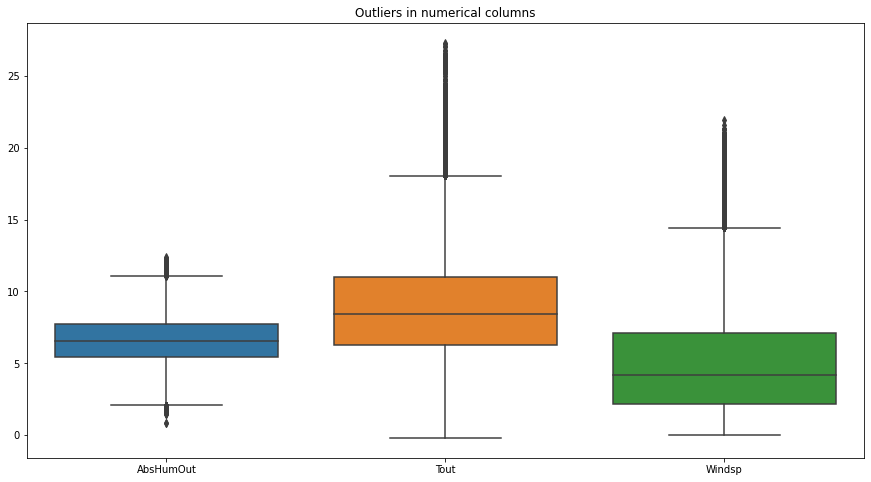

In [23]:
# Outlier analysis
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=weather_df[['AbsHumOut', 'Tout', 'Windsp']])
ax.set_title("Outliers in numerical columns")
plt.show()

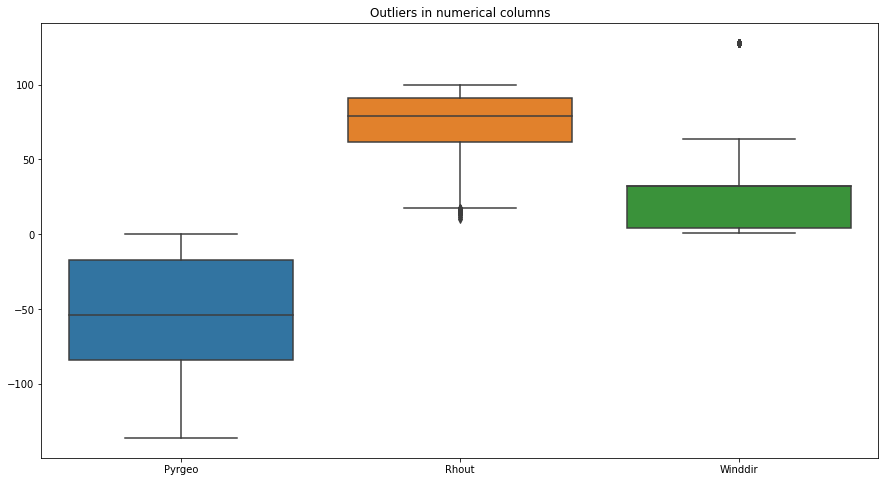

In [24]:
# Outlier analysis
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=weather_df[['Pyrgeo', 'Rhout', 'Winddir']])
ax.set_title("Outliers in numerical columns")
plt.show()

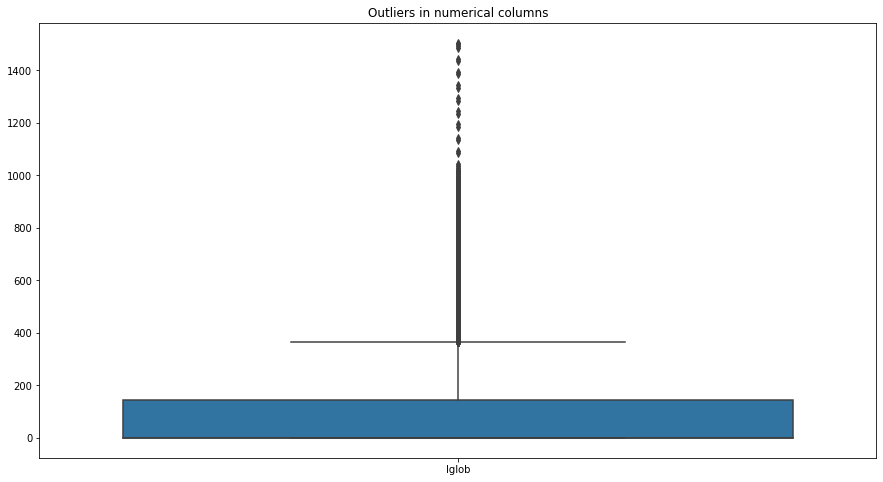

In [25]:
# Outlier analysis
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=weather_df[['Iglob']])
ax.set_title("Outliers in numerical columns")
plt.show()

### Load and transform the Automatoes dataset

In [26]:
automatoes_df = load_data("../dataset/ghclimate_automatoes.csv")

In [27]:
automatoes_df

,time,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,...,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
0,43815.00000,0.0,35.000000,468.000000,0.26,1.78,96.0,7.32,34.5,50.4,...,NaN,0.0,NaN,25.0,26.0,2.0,NaN,1000.0,NaN,1.2
1,43815.00347,0.0,85.000001,508.999999,0.52,1.78,96.0,7.08,33.2,48.7,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
2,43815.00694,0.0,95.999999,498.000001,0.52,1.78,96.0,7.48,32.4,47.1,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
3,43815.01042,0.0,96.000000,491.000001,0.52,1.76,96.0,6.55,31.7,45.4,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
4,43815.01389,0.0,95.400000,514.999999,0.52,1.78,95.4,6.71,30.9,44.2,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47804,43980.98611,0.0,0.000000,493.000000,2.86,7.84,0.0,3.46,0.0,0.0,...,NaN,0.0,18.0,18.0,18.0,22.0,NaN,1080.0,0.0,0.0
47805,43980.98958,0.0,0.000000,493.000000,2.86,7.84,0.0,3.35,0.0,0.0,...,NaN,0.0,18.0,18.0,18.0,22.0,NaN,1080.0,0.0,0.0
47806,43980.99306,0.0,0.000000,485.000000,2.86,7.86,0.0,3.26,0.0,0.0,...,NaN,0.0,18.0,18.0,18.0,22.0,NaN,1080.0,0.0,0.0
47807,43980.99653,0.0,0.000000,502.000000,2.86,7.85,0.0,3.08,0.0,0.0,...,NaN,0.0,18.0,18.0,18.0,22.0,NaN,1080.0,0.0,0.0


In [28]:
# only extract the target variable column

automatoes_df = automatoes_df[['time', 'Tair']]

In [29]:
automatoes_df

,time,Tair
0,43815.00000,21.3
1,43815.00347,21.5
2,43815.00694,22.0
3,43815.01042,21.3
4,43815.01389,21.6
...,...,...
47804,43980.98611,18.3
47805,43980.98958,18.3
47806,43980.99306,18.3
47807,43980.99653,18.0


In [30]:
automatoes_df.isnull().sum()

time     0
Tair    71
dtype: int64

In [31]:
automatoes_df = preprocess_df(automatoes_df)

In [32]:
automatoes_df

,Tair
time,
2019-12-16 00:00:00.000,21.3
2019-12-16 00:04:59.808,21.5
2019-12-16 00:09:59.616,22.0
2019-12-16 00:15:00.288,21.3
2019-12-16 00:20:00.096,21.6
...,...
2020-05-29 23:35:00.096,18.3
2020-05-29 23:39:59.904,18.3
2020-05-29 23:44:59.712,18.3


In [33]:
automatoes_df.isnull().sum()

Tair    0
dtype: int64

In [34]:
automatoes_df.dtypes

Tair    float64
dtype: object

### Outlier analysis

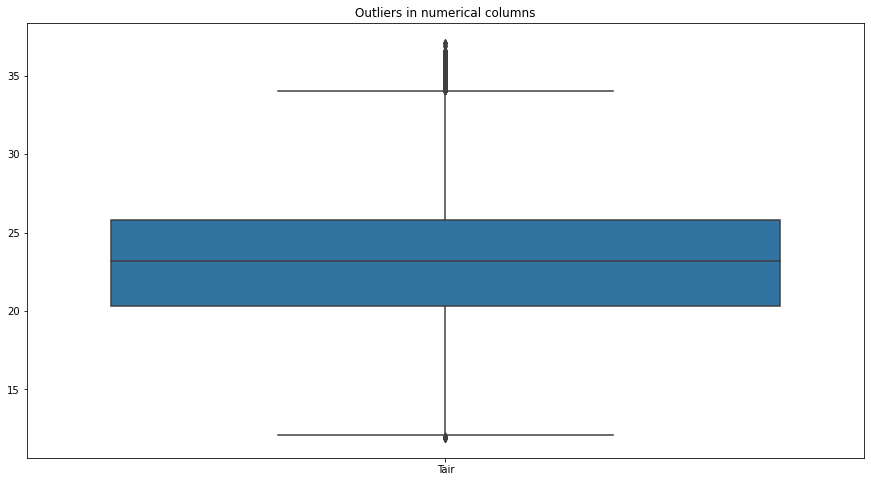

In [35]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=automatoes_df[['Tair']])
ax.set_title("Outliers in numerical columns")
plt.show()

### Merge the weather dataset consisting of independent variables and greenhouse climate dataset consisting of dependent variable

In [36]:
final_df = pd.merge(weather_df, automatoes_df, on='time', how='inner')

In [37]:
final_df

,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rain,Rhout,Tout,Winddir,Windsp,Tair
time,,,,,,,,,,,
2019-12-16 00:00:00.000,6.220954,0.0,0.000000e+00,-72.0,215.0,0,80.6,6.9,32.0,4.7,21.3
2019-12-16 00:04:59.808,6.220954,0.0,0.000000e+00,-73.0,0.0,0,80.6,6.9,32.0,4.7,21.5
2019-12-16 00:09:59.616,6.205565,0.0,0.000000e+00,-76.0,0.0,0,80.4,6.9,32.0,4.7,22.0
2019-12-16 00:15:00.288,6.190173,0.0,0.000000e+00,-77.0,0.0,0,80.2,6.9,32.0,4.7,21.3
2019-12-16 00:20:00.096,6.162624,0.0,0.000000e+00,-75.0,0.0,0,80.9,6.7,32.0,4.7,21.6
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-29 23:35:00.096,9.395935,0.0,6.710000e-08,-84.0,2992.0,0,71.8,15.2,2.0,4.3,18.3
2020-05-29 23:39:59.904,9.286397,0.0,9.999999e-01,-85.0,2992.0,0,71.4,15.1,2.0,4.3,18.3
2020-05-29 23:44:59.712,9.242139,0.0,1.000000e+00,-85.0,2992.0,0,71.5,15.0,2.0,4.3,18.3


In [38]:
final_df.dtypes

AbsHumOut     float64
Iglob         float64
PARout        float64
Pyrgeo        float64
RadSum        float64
Rain         category
Rhout         float64
Tout          float64
Winddir       float64
Windsp        float64
Tair          float64
dtype: object

In [39]:
# Encode the dataset
final_df = pd.get_dummies(final_df, columns=['Rain'])

In [40]:
final_df

,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rhout,Tout,Winddir,Windsp,Tair,Rain_0,Rain_1
time,,,,,,,,,,,,
2019-12-16 00:00:00.000,6.220954,0.0,0.000000e+00,-72.0,215.0,80.6,6.9,32.0,4.7,21.3,1,0
2019-12-16 00:04:59.808,6.220954,0.0,0.000000e+00,-73.0,0.0,80.6,6.9,32.0,4.7,21.5,1,0
2019-12-16 00:09:59.616,6.205565,0.0,0.000000e+00,-76.0,0.0,80.4,6.9,32.0,4.7,22.0,1,0
2019-12-16 00:15:00.288,6.190173,0.0,0.000000e+00,-77.0,0.0,80.2,6.9,32.0,4.7,21.3,1,0
2019-12-16 00:20:00.096,6.162624,0.0,0.000000e+00,-75.0,0.0,80.9,6.7,32.0,4.7,21.6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-29 23:35:00.096,9.395935,0.0,6.710000e-08,-84.0,2992.0,71.8,15.2,2.0,4.3,18.3,1,0
2020-05-29 23:39:59.904,9.286397,0.0,9.999999e-01,-85.0,2992.0,71.4,15.1,2.0,4.3,18.3,1,0
2020-05-29 23:44:59.712,9.242139,0.0,1.000000e+00,-85.0,2992.0,71.5,15.0,2.0,4.3,18.3,1,0


### Split the dataset into train and test

In [41]:
def train_test_split(data, train_size):
    data.reset_index(inplace=True)
    data.drop('time', axis=1, inplace=True)
    
    train_set = data[:int(len(data)*train_size)]
    test_set = data[int(len(data)*train_size):]
    
    train_columns = data.columns.drop('Tair')
    
    X_train, Y_train = train_set[train_columns], train_set['Tair']
    X_test, Y_test = test_set[train_columns], test_set['Tair']
    
    return X_train, Y_train, X_test, Y_test


In [42]:
X_train, Y_train, X_test, Y_test = train_test_split(final_df, 0.7)

In [43]:
X_train

,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rhout,Tout,Winddir,Windsp,Rain_0,Rain_1
0,6.220954,0.0,0.0,-72.0,215.0,80.6,6.9,32.0,4.7,1,0
1,6.220954,0.0,0.0,-73.0,0.0,80.6,6.9,32.0,4.7,1,0
2,6.205565,0.0,0.0,-76.0,0.0,80.4,6.9,32.0,4.7,1,0
3,6.190173,0.0,0.0,-77.0,0.0,80.2,6.9,32.0,4.7,1,0
4,6.162624,0.0,0.0,-75.0,0.0,80.9,6.7,32.0,4.7,1,0
...,...,...,...,...,...,...,...,...,...,...,...
33411,6.002594,0.0,0.0,-70.0,0.0,80.9,6.3,2.0,1.2,1,0
33412,5.948462,0.0,0.0,-71.0,0.0,80.7,6.2,2.0,1.2,1,0
33413,5.911712,0.0,0.0,-70.0,0.0,80.2,6.2,2.0,1.2,1,0
33414,5.874959,0.0,0.0,-69.0,0.0,79.7,6.2,2.0,1.2,1,0


In [44]:
Y_train

0        21.3
1        21.5
2        22.0
3        21.3
4        21.6
         ... 
33411    20.6
33412    20.6
33413    20.7
33414    20.7
33415    20.8
Name: Tair, Length: 33416, dtype: float64

### Normalize the independent features

In [45]:
from sklearn.preprocessing import MinMaxScaler

def scale(data):
    scaler = MinMaxScaler()

    X_scaled = scaler.fit_transform(data[numerical_columns])

    data.loc[:, numerical_columns] = X_scaled
    
    return None

In [46]:
# Normalization increases the RMSE score for the Linear regression model
# scale(X_train)
# scale(X_test)

## TimeSeries Cross Validation

In [47]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import math

tscv = TimeSeriesSplit(n_splits=5)

def TimeSeriesCV(ts_split, X_train, Y_train, model):
    result = []
    
    for train_index, test_index in ts_split.split(X_train, Y_train):
        train_x = X_train.iloc[train_index]
        train_y = Y_train.iloc[train_index]
    
        test_x = X_train.iloc[test_index]
        test_y = Y_train.iloc[test_index]
        
        model.fit(train_x, train_y)
        pred_y = model.predict(test_x)
        score = math.sqrt(mean_squared_error(test_y, pred_y))
        
        result.append(score)
    return np.mean(result)
    

## Linear Regression

In [48]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr_rmse = TimeSeriesCV(tscv, X_train, Y_train, lr)

#### RMSE score on cross-validation

In [49]:
lr_rmse

3.0429873599271886

#### RMSE score on test set

In [50]:
lr.fit(X_train, Y_train)

LinearRegression()

In [51]:
pred = lr.predict(X_test)

In [52]:
math.sqrt(mean_squared_error(Y_test, pred))

3.784701561190209

In [53]:
pred

array([21.04562771, 21.0308016 , 21.06659462, ..., 18.43806591,
       18.48725969, 18.47140817])

### Forecast Tair for the next 24h with 1h intervals

In [54]:
def forecast(prediction):
    hour_count = 1
    for i in range(1,289):
        '''
        Parameters
        ----------
        prediction: array with predictions for 5min intervals
        
        NOTE:
        Since our input dataset has values in every 5min intervals,
        our output is also generated in 5min intervals. To convert
        this to hourly predictions, we take the 12th prediction
        (60/5 = 12) and to make predictions until the 24th hour,
        we take until 288th (12*24=288) prediction. 
        '''
        if i%12==0:
            print(f"t={hour_count} | Tair = {prediction[i-1]}")
            hour_count +=1

### Feature selection: RFE